<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Data-prep" data-toc-modified-id="Data-prep-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data prep</a></span></li><li><span><a href="#Impute-data" data-toc-modified-id="Impute-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Impute data</a></span></li><li><span><a href="#Calculate-cumulative-sums" data-toc-modified-id="Calculate-cumulative-sums-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate cumulative sums</a></span></li><li><span><a href="#Create-a-spline" data-toc-modified-id="Create-a-spline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create a spline</a></span><ul class="toc-item"><li><span><a href="#Plot-daily-recoveries" data-toc-modified-id="Plot-daily-recoveries-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Plot daily recoveries</a></span></li><li><span><a href="#Plot-cubicspline(x)" data-toc-modified-id="Plot-cubicspline(x)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Plot <code>cubicspline(x)</code></a></span></li></ul></li></ul></div>

### Import libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import random

### Data prep

In [3]:
df = pd.read_csv("output/city_stats.csv", index_col=["date"])
df.index = pd.to_datetime(df.index)
df = df[df.district == "Mumbai"]
drop_rows = df[df.index < "2020-04-25"]
df.drop(drop_rows.index, axis=0, inplace=True)
if not "delta.other" in df.columns:
    df["delta.other"] = 0
if not "total.other" in df.columns:
    df["total.other"] = 0
df.loc[df["delta.tested"]<0, ["delta.tested"]] = np.nan
df.loc[df["delta.confirmed"]<0, ["delta.confirmed"]] = np.nan

### Impute data

In [4]:
def imputeCols(col):
    col = pd.Series(np.where(col < 0, np.NaN, col))
    preNaNs = col.isnull().astype(int).groupby(col.notnull().astype(int).cumsum()).cumsum().shift(1) + 1
    #print(preNaNs)
    avgs = np.round(col/preNaNs)
    avgs = avgs.bfill()
    
    avgs = np.where(np.logical_or(np.isnan(col), avgs < col), avgs, col)
    
    avgs = pd.Series(avgs)
    avgs.fillna(np.round(avgs.mean()), inplace=True)
    
    return avgs.to_numpy()

In [5]:
df["delta.tested"] = imputeCols(df["delta.tested"])
df["delta.confirmed"] = imputeCols(df["delta.confirmed"])
df["delta.deceased"] = imputeCols(df["delta.deceased"])
df["delta.recovered"] = imputeCols(df["delta.recovered"])
df["delta.other"] = imputeCols(df["delta.other"])

### Calculate cumulative sums

In [9]:
df["total.confirmed"] = df["delta.confirmed"].cumsum()
df["total.tested"] = df["delta.tested"].cumsum()
df["total.recovered"] = df["delta.recovered"].cumsum() 
df["total.deceased"] = df["delta.deceased"].cumsum() 
df["total.other"] = df["delta.other"].cumsum()
df["delta.active"] = df["total.confirmed"] - df["total.deceased"] - df["total.recovered"] - df["total.other"]

### Create a spline

Spline documentation is available [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html). 

I have assumed that `x = 0,1,2,3,...` a monotonically increasing sequence of days, `y` is a parameter. Let's assume `daily recoveries` here. 

In [10]:
from scipy.interpolate import CubicSpline

In [13]:
x = range(df.shape[0])
y = df["delta.recovered"]
cs = CubicSpline(x,y)

#### Plot daily recoveries

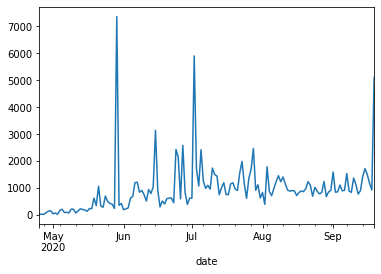

In [11]:
df["delta.recovered"].plot()

#### Plot `cubicspline(x)` 

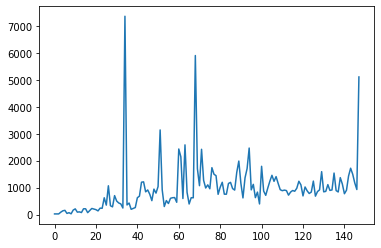

In [16]:
pd.Series(cs(x)).plot()